# Residual Split expirement 

In [41]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Hi , these are the results on the residual split test,
bottom line, see below results on accuracy per derived net: (showing improvment compared to the previous flow)

  Net  | Acc
  ------------- | -------------
  Baseline  | 0.653201
  Derived1  | 0.6617
  Derived2  | 0.6802
  Derived3  | 0.686
  Derived4  | 0.69
  Derived5  | 0.6914

In [30]:
! grep -R -B 3 "Optimization Done" ../../caffe/exp/test_residual_split/* | grep accuracy

../../caffe/exp/test_residual_split/baseline/baseline_relu_lsuv.log-I0213 23:02:27.650948 26554 solver.cpp:408]     Test net output #0: accuracy = 0.653201
../../caffe/exp/test_residual_split/derived1/train.log-I0227 19:20:37.299788 15671 solver.cpp:433]     Test net output #0: accuracy = 0.6617
../../caffe/exp/test_residual_split/derived2/train.log-I0228 12:31:37.931709 24487 solver.cpp:433]     Test net output #0: accuracy = 0.6802
../../caffe/exp/test_residual_split/derived3/train.log-I0228 16:18:08.396566  9374 solver.cpp:433]     Test net output #0: accuracy = 0.686
../../caffe/exp/test_residual_split/derived4/train.log-I0228 21:50:04.230151 28318 solver.cpp:433]     Test net output #0: accuracy = 0.69
../../caffe/exp/test_residual_split/derived5/train.log-I0301 11:51:10.079383  8434 solver.cpp:433]     Test net output #0: accuracy = 0.6914


these were the results on the "previous split":

Net  | Acc
------------- | -------------
Baseline  | 0.653201
Derived1  | 0.661601
Derived2  | 0.6703
Derived3  | 0.682801
Derived4  | 0.683501
Derived5  | 0.6867
Derived6  | 0.681701   

In [6]:
! grep -R -B 3 "Optimization Done" ../../caffe/exp/test_split3/* | grep accuracy

../../caffe/exp/test_split3/baseline/baseline_relu_lsuv.log-I0213 23:02:27.650948 26554 solver.cpp:408]     Test net output #0: accuracy = 0.653201
../../caffe/exp/test_split3/derived1/train.log-I0215 12:41:19.712880  4473 solver.cpp:433]     Test net output #0: accuracy = 0.661601
../../caffe/exp/test_split3/derived2/train.log-I0218 15:02:11.504654 31085 solver.cpp:433]     Test net output #0: accuracy = 0.6703
../../caffe/exp/test_split3/derived3/train.log-I0220 00:25:52.106156 11071 solver.cpp:433]     Test net output #0: accuracy = 0.682801
../../caffe/exp/test_split3/derived4/train.log-I0221 19:30:28.008002 24446 solver.cpp:433]     Test net output #0: accuracy = 0.683501
../../caffe/exp/test_split3/derived5/train.log-I0222 20:42:30.740097 32722 solver.cpp:433]     Test net output #0: accuracy = 0.6867
../../caffe/exp/test_split3/derived6/train.log-I0223 20:30:18.533768  3564 solver.cpp:433]     Test net output #0: accuracy = 0.681701


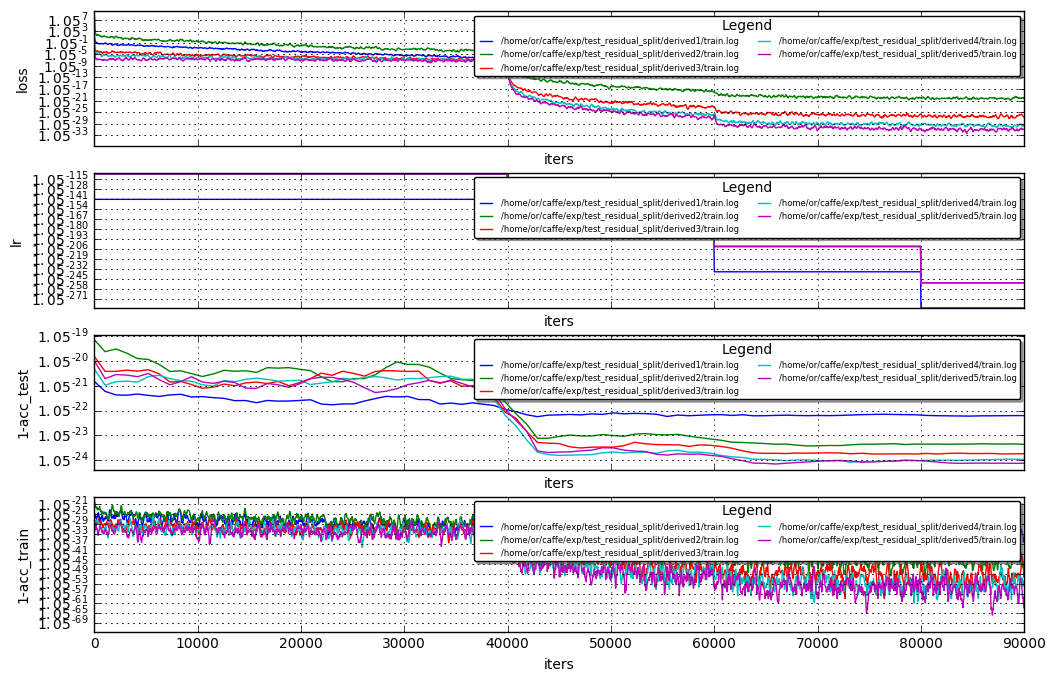

In [42]:
%run /home/or/caffe/utils/plot_loss.py  /home/or/caffe/exp/test_residual_split/derived1/train.log  /home/or/caffe/exp/test_residual_split/derived2/train.log /home/or/caffe/exp/test_residual_split/derived3/train.log /home/or/caffe/exp/test_residual_split/derived4/train.log /home/or/caffe/exp/test_residual_split/derived5/train.log --avg 5

### Description of the split method

##### baseline

To be more specific, this is the description of the split:<br>
see below the process of producing the output blob conv1_1 , that is feed to the rest of the net.<br>
in the baseline conv1_1 is a convoltion layer applied on the input image: (see below)

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
import cv2

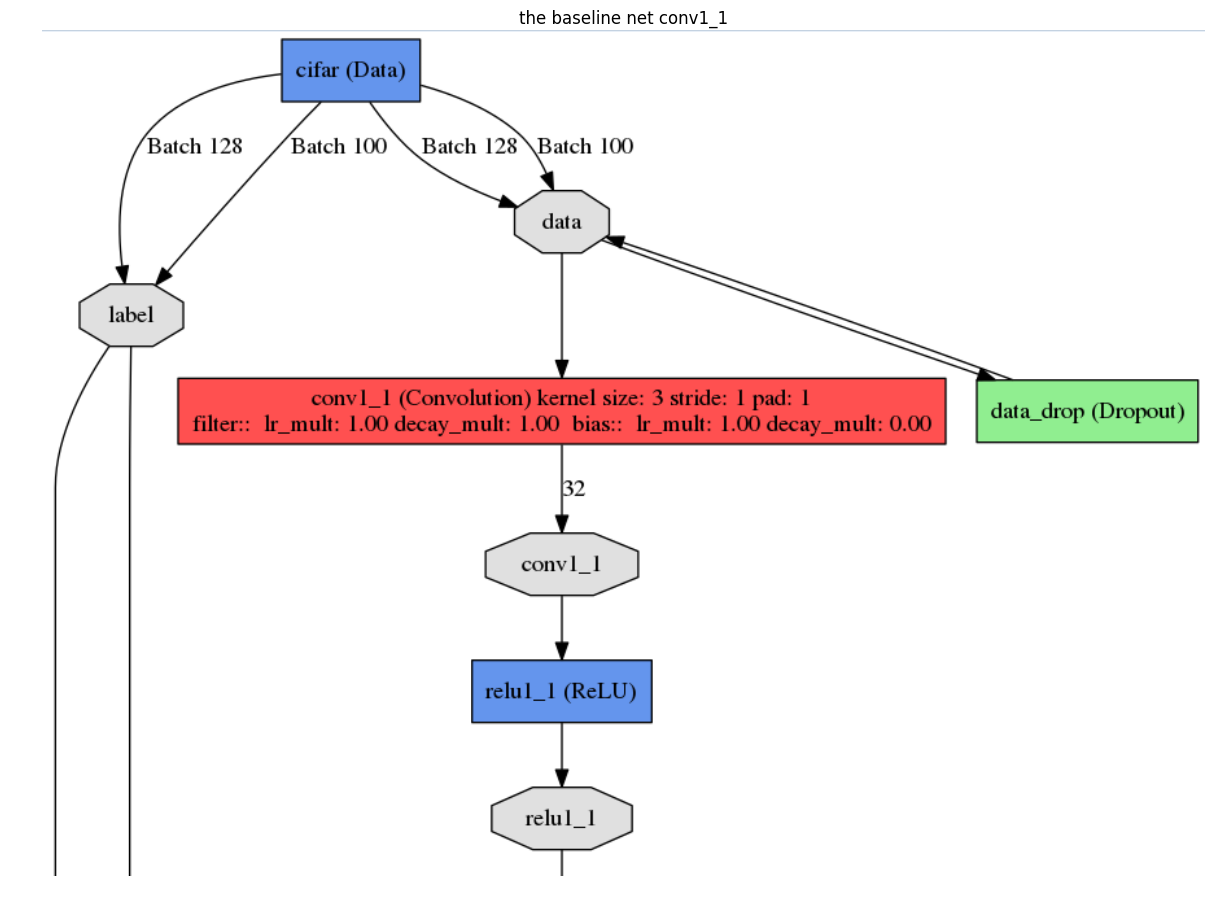

In [7]:
plt.figure(figsize=(15,15))
plt.axis("off")
plt.imshow(cv2.imread('net_baseline.PNG')[:,:,::-1])
plt.title("the baseline net conv1_1")

##### prev(old) split

this is how the conv1_1 was produce in the prev(old) split flow:<br>
conv1_1_split1 are the "fast" kernels (high TPM) , conv1_1_split2 are the "slower" kernels (lower TPM)<br>
conv1_1_split2 are feed to an "extention" conv layer with kernel size 1,<br>(initilaized with identity matrix + noise)<br>
the concatiantion of conv1_1_split1 , conv1_1_split2_extention is feed to a "reorder" conv layer with kernel size 1<br>(initialized with premutated indentity matrix + noise , where the permutation is in order to perserve the previouse conv1_1 convolution function)<br>
NOTE: if the noise in the initializtion was zero, network mapping (the network output given an image) after the split was identical to the base network 

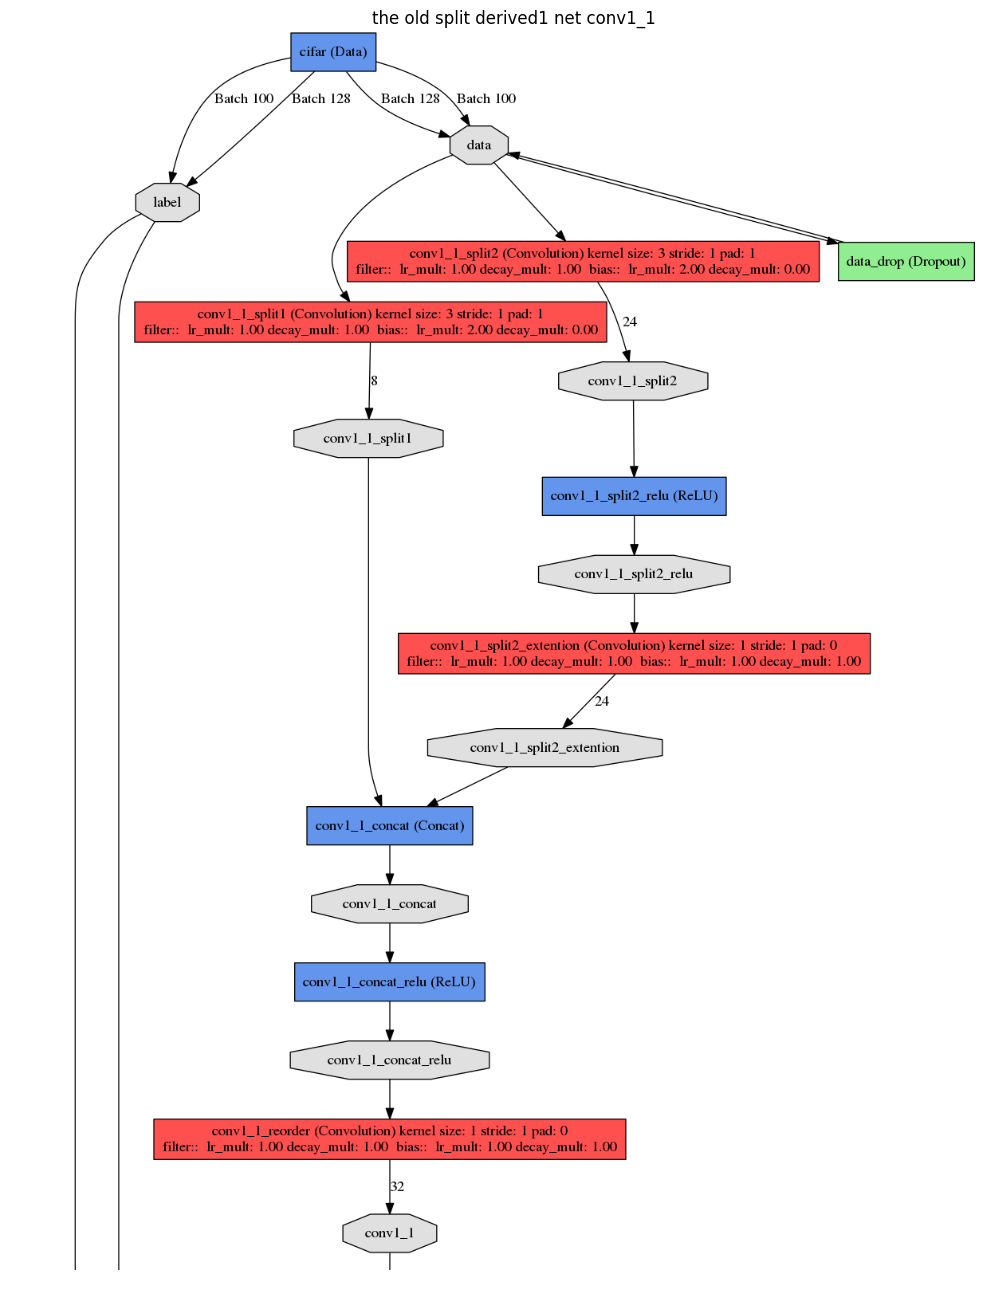

In [19]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(cv2.imread('net_old_split.png')[:,:,::-1])
plt.title("the old split derived1 net conv1_1")

##### residual split

conv1_1_split1 are the "fast" kernels (high TPM) , conv1_1_split2 are the "slower" kernels (lower TPM)<br>
conv1_1_split2 is element wise summed with a residual path:<br>
the residual path is built from conv1_1_split2_residual_pre , (with identical kernel size to the conv1_1_split2) and a conv1_1_split2_residual_post with kernel_size =1 conv layer.<br>
<br>
Next, both splits are concatinated and reordered as before<br>
- The initialization of the conv1_1_split2_residual_post is a noisey identity matrix<br>
- The initialization of the conv1_1_split2_residual_pre is -0.2 * conv1_1_split2  + 2 * conv1_1_split2(spatial_center),<br>
meaning negative weights of the conv1_1_split2 , where only the center weight is positive.<br>
I did it in order to make the residaul path more "edge perserving"<br>


<br>
NOTE: by this initialization I'm training to preserve the base net accuracy , meaning that the drop of the accuracy in the new generated net is about ~15%, (i.e. the training on the derived net start from 57% accuracy instead of 10% )
<br>
<br>
see below the visualization of the conv1_1_split2_residual_pre initialization:

In [17]:
def sigmoid(x):
    return 1./(np.exp(-1*x) + 1)

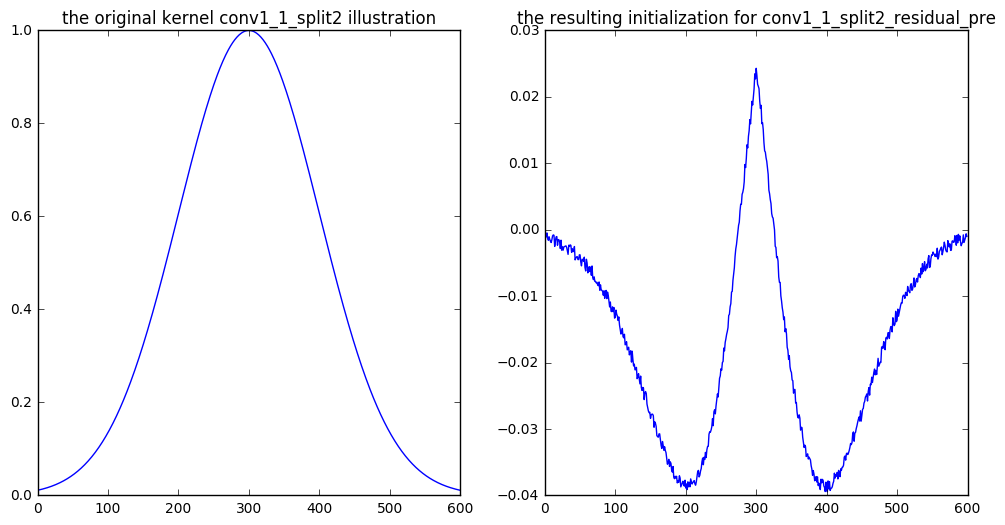

In [46]:
from scipy.spatial.distance import pdist, squareform
%matplotlib inline

plt.figure(figsize=(12,6))
plt.subplot(121)
X = np.arange(-3,3,0.01)
K = np.exp(-1 * (X ** 2) / 2)
plt.plot(K)
plt.title("the original kernel conv1_1_split2 illustration")
plt.subplot(122)
K = -0.2*np.exp(-1 * (X ** 2) / 2) * (sigmoid(np.abs(2*X)-0.5) - 0.5) + np.random.uniform(-0.001,0.001,K.shape)
plt.plot(K)
plt.title("the resulting initialization for conv1_1_split2_residual_pre")

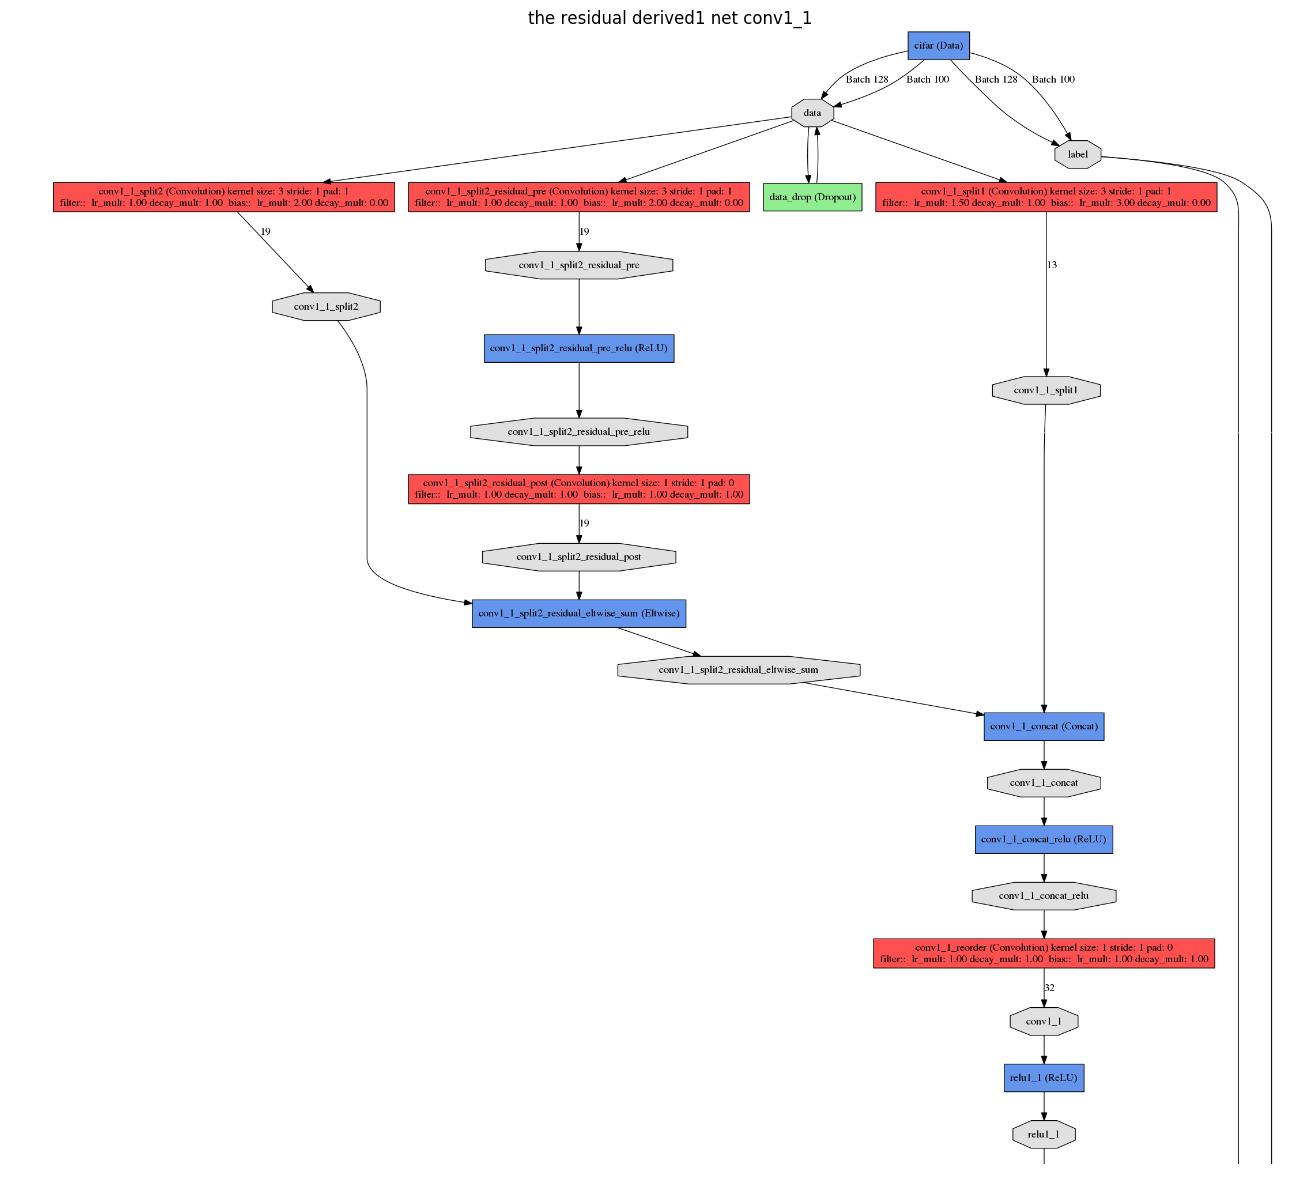

In [17]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.imshow(cv2.imread('net_derived1.png')[:,:,::-1])
plt.title("the residual derived1 net conv1_1")